### Import all Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda  # Corrected import statement
from keras.layers import Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers import Conv1D
from keras import backend as K
from keras.callbacks import EarlyStopping

print("Setup Complete")


Setup Complete


In [2]:
# Load the Data
data = pd.read_csv(r"C:\Users\VARUN\Downloads\train_data.csv")
test = pd.read_csv(r"C:\Users\VARUN\Downloads\test_data.csv")
test_prediction = pd.read_csv(r"C:\Users\VARUN\Downloads\test_data_hidden.csv")

In [3]:
data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [4]:
# To check the shape of data
data.shape

(4000, 8)

In [5]:
# To check basic information of the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [6]:
# Get summary statistics for numerical columns
data.describe()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [7]:
# Check for missing values in the dataframe
data.isnull().sum()

Name of the product     0
Product Brand           0
categories              0
primaryCategories       0
reviews.date            0
reviews.text            0
reviews.title          10
sentiment               0
dtype: int64

In [8]:
# Get the list of columns 
data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [9]:
# count the number of Duplicate rows in the DataFrame
data.duplicated().sum()

58

In [10]:
Positive = data[data['sentiment']== "Positive"].iloc[:,[5,6,7]]
Neutral = data[data['sentiment']== "Neutral"].iloc[:,[5,6,7]]
Negative = data[data['sentiment']== "Negative"].iloc[:,[5,6,7]]

In [11]:
Positive['sentiment'].value_counts()

sentiment
Positive    3749
Name: count, dtype: int64

In [12]:
Neutral['sentiment'].value_counts()

sentiment
Neutral    158
Name: count, dtype: int64

In [13]:
Negative['sentiment'].value_counts()

sentiment
Negative    93
Name: count, dtype: int64

primaryCategories
Electronics                    2600
Electronics,Hardware           1159
Office Supplies,Electronics     224
Electronics,Media                17
Name: count, dtype: int64


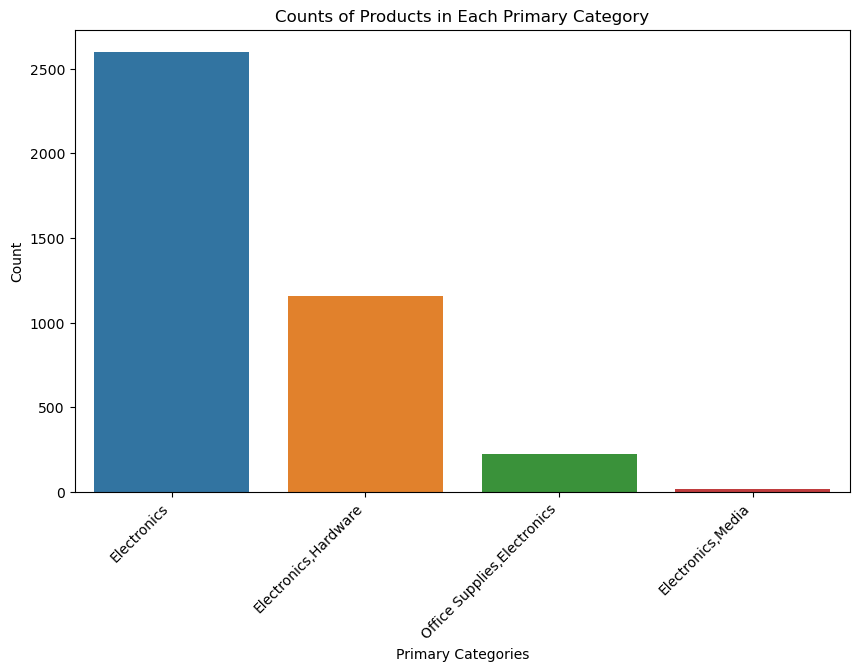

In [14]:
# count the occurences of unique values in a columns
print(data['primaryCategories'].value_counts())


# Visualize counts using a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='primaryCategories', data=data, order=data['primaryCategories'].value_counts().index)
plt.title('Counts of Products in Each Primary Category')
plt.xlabel('Primary Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [15]:
# print counts for reviews.title
print(data['reviews.title'].value_counts())

reviews.title
Great tablet                                  100
Great product                                  63
Love it                                        52
Great                                          49
Great for kids                                 43
                                             ... 
Love my Amazon Echo Plus                        1
Easy tablet                                     1
This is the third Kindle I have purchased.      1
In love                                         1
A great 7 inch tablet at a great price          1
Name: count, Length: 2606, dtype: int64


sentiment
Positive    3749
Neutral      158
Negative      93
Name: count, dtype: int64


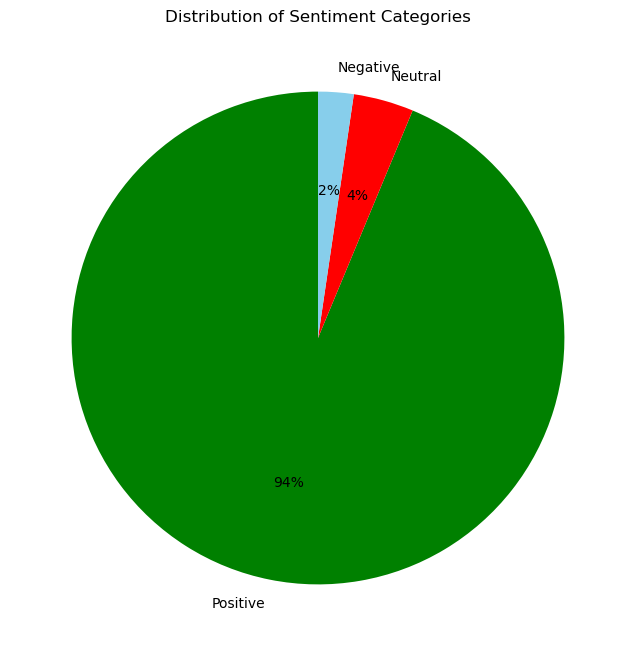

In [16]:
# Print counts of each sentiment category
print(data['sentiment'].value_counts())

# Visualize counts using a pie chart
plt.figure(figsize=(8, 8))
data['sentiment'].value_counts().plot.pie(autopct='%1.0f%%', startangle=90, colors=['green', 'Red', 'skyblue'])
plt.title('Distribution of Sentiment Categories')
plt.ylabel('')  # Remove y-axis label for better presentation
plt.show()

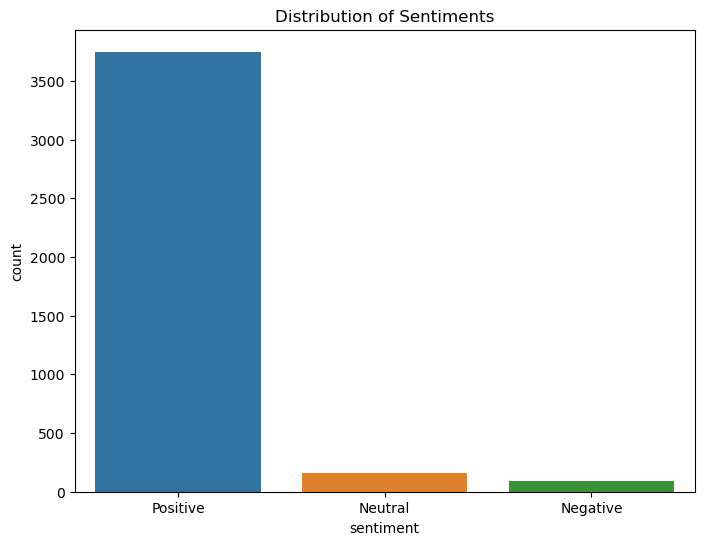

In [17]:
# Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of Sentiments')
plt.show()

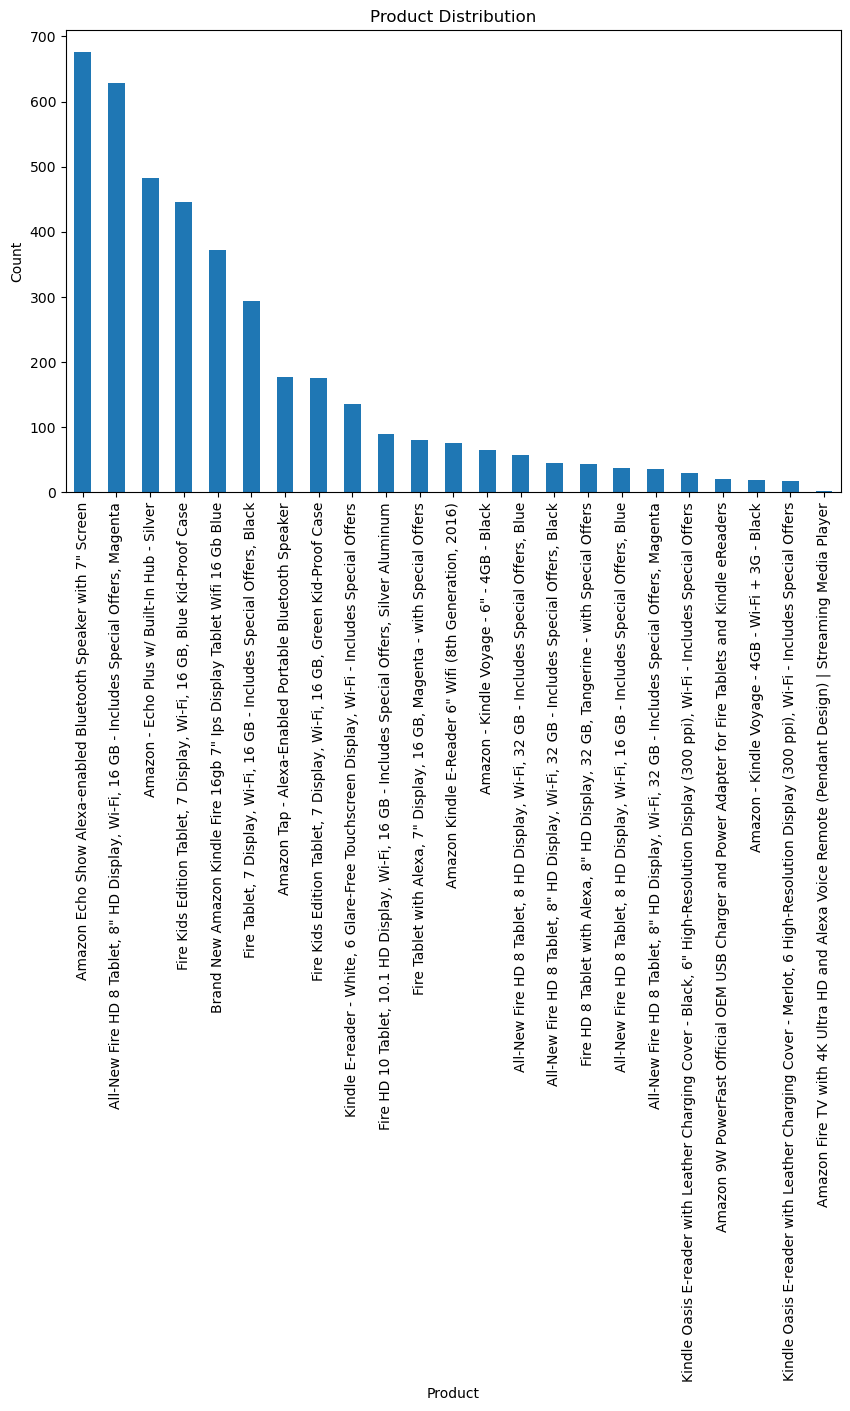

In [18]:
# Print counts of each Name of product
product_counts=data['Name of the product'].value_counts()

# Plotting a bar chart
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar')
plt.title('Product Distribution')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()



In [19]:
# Now we check Test Data
test.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [20]:
# To check the shape of the data
test.shape

(1000, 7)

In [21]:
# check null values
test.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          3
dtype: int64

In [22]:
# check info values of the data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   object
 2   categories           1000 non-null   object
 3   primaryCategories    1000 non-null   object
 4   reviews.date         1000 non-null   object
 5   reviews.text         1000 non-null   object
 6   reviews.title        997 non-null    object
dtypes: object(7)
memory usage: 54.8+ KB


#### Now we are ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative sentiment.¶

In [23]:
pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:

from wordcloud import WordCloud
from wordcloud import WordCloud,STOPWORDS


Positive words


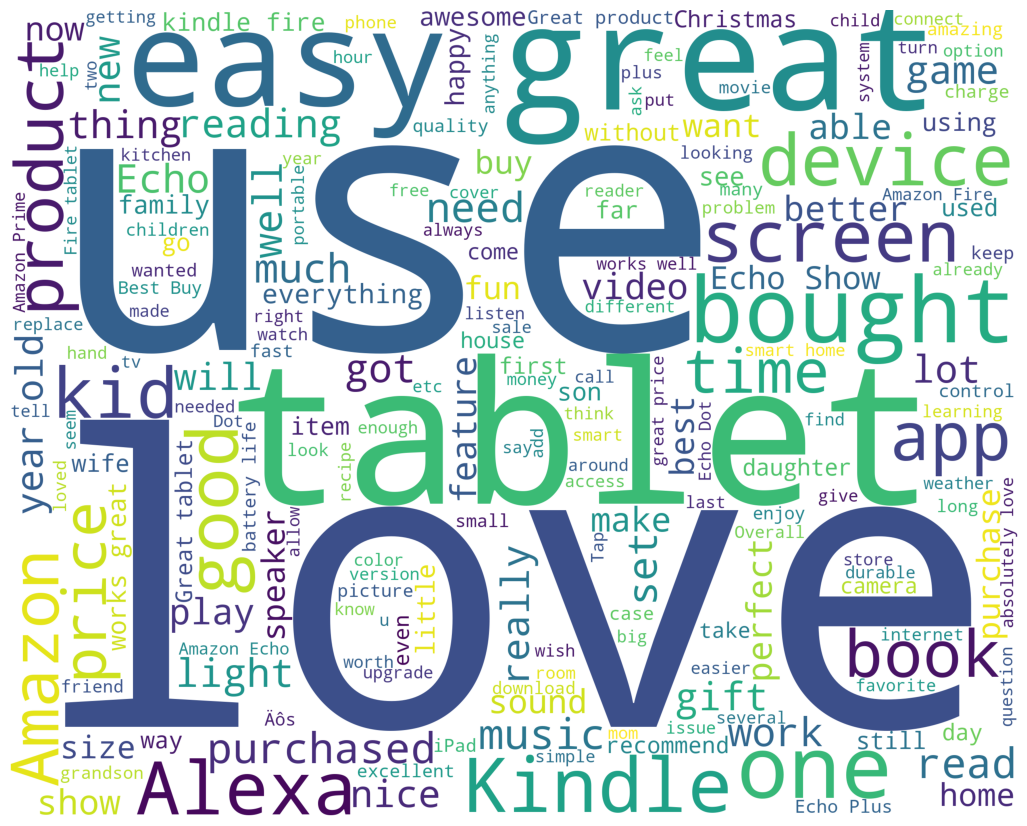

Negative words


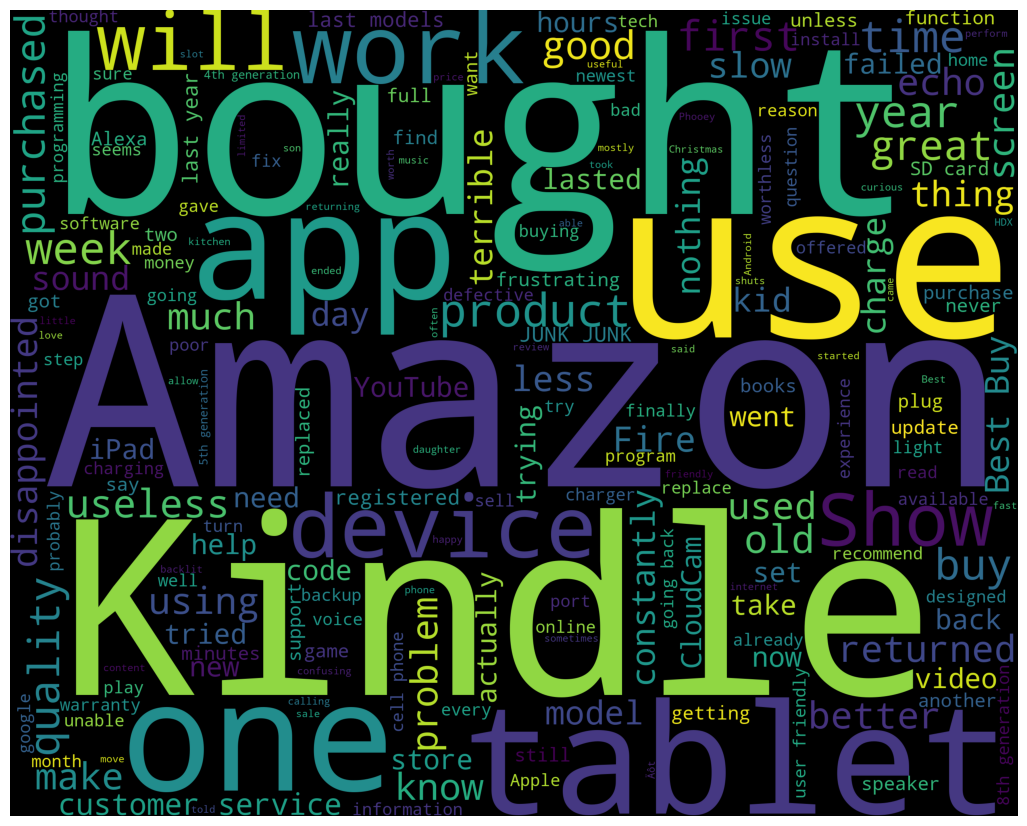

In [25]:
# Separate positive and negative reviews
train_pos = data[data['sentiment']=='Positive']
train_pos = train_pos['reviews.text']

train_neg = data[data['sentiment'] == 'Negative']
train_neg = train_neg['reviews.text']

# Define a function to generate and display word clouds
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    
    # Clean the text by removing URLs, mentions, hashtags, and 'RT'
    cleaned_word = ' '.join([word for word in words.split()
                             if 'http'not in word 
                             and not word .startswith('@')
                             and not word.startswith('#')
                             and word != 'RT'
                             ])
    
     # Generate the word cloud
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = color,
                         width = 2500,
                         height=2000
                         ).generate(cleaned_word)
    
     # Display the word cloud
    plt.figure(1,figsize=(13 ,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

    
# Display word cloud for positive reviews
print("Positive words")
wordcloud_draw(train_pos,'white')

# Display word cloud for negative reviews
print("Negative words")
wordcloud_draw(train_neg)    

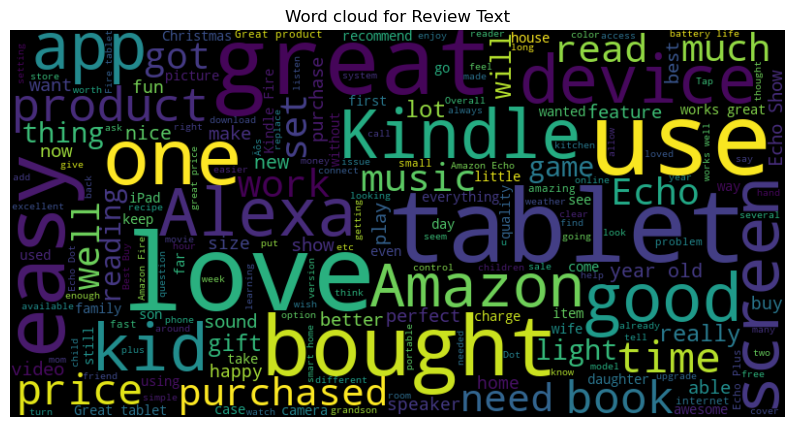

In [26]:
# Word cloud for review text
text = ' '.join(data['reviews.text'].astype(str))
wordcloud = WordCloud(width = 800 ,height=400,random_state =21,max_font_size=110).generate(text)


plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.title('Word cloud for Review Text')
plt.show()

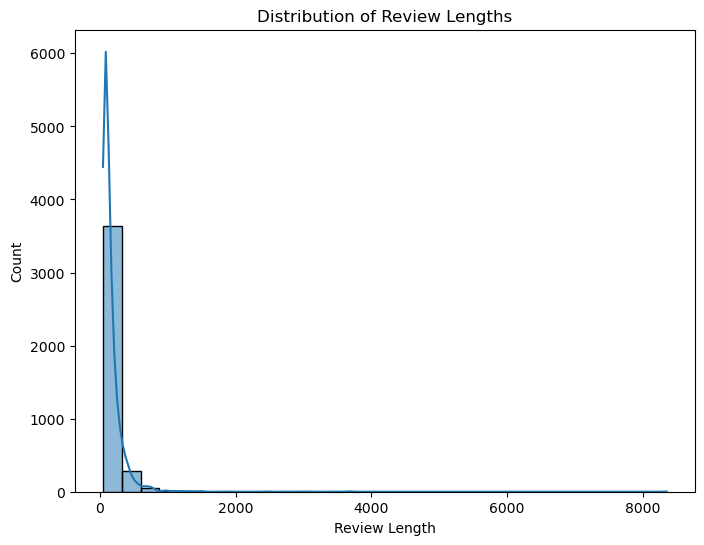

In [27]:

# Distribution of Review Lengths
data['review_length'] = data['reviews.text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.show()


### Converting the Reviews as Tf-Idf Score

TF-IDF stands for term frequency-inverse document frequency.
It is a statistical calculation that measures 
the importance of a word to a document in a collection. 
TF-IDF scores range from 0 to 1, with higher scores 
indicating rarer terms and lower scores 
indicating more common terms. 

In [28]:
# Selecting only the relevant features for further exploration.

data1 = data[["sentiment" ,"reviews.text"]]

data1.head()






,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


In [29]:
# Resetting the Index
data1.index = pd.Series(list(range(data1.shape[0])))

In [30]:
print('Shape :' ,data1.shape)
data1.head()

Shape : (4000, 2)


,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


### Creating Preprocessing Function & Applying it on the Data

The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning

In [31]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')


wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() #convert to lowercase
    words = tokenizer.tokenize(document) # tokenize the words
    words = [w for w in words if not w in stop_words] # Removing stopwords
    
    #Lemmatizing
    for pos in [wordnet.NOUN,wordnet.VERB,wordnet.ADJ,wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x , pos) for x in words]
        
    return " ".join(words)
    
print("Setup Complete")


Setup Complete


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VARUN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VARUN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Overall, this code sets up preprocessing functions for text data using NLTK, including tokenization, stopword removal, and lemmatization, making the text data ready for further analysis or modeling.

In [32]:
data1['Processed_Review'] = data1['reviews.text'].apply(preprocess)

data1.head()

C:\Users\VARUN\AppData\Local\Temp\ipykernel_9952\3305826758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Processed_Review'] = data1['reviews.text'].apply(preprocess)


,sentiment,reviews.text,Processed_Review
0,Positive,Purchased on Black FridayPros - Great Price (e...,purchase black fridaypros great price even sal...
1,Positive,I purchased two Amazon in Echo Plus and two do...,purchase two amazon echo plus two dot plus fou...
2,Neutral,Just an average Alexa option. Does show a few ...,average alexa option show thing screen still l...
3,Positive,"very good product. Exactly what I wanted, and ...",good product exactly want good price
4,Positive,This is the 3rd one I've purchased. I've bough...,rd one purchase buy one niece case compare one...


In [33]:
# Select the columns Sentiment and Processed Review for further analysis

data2= data1[['sentiment','Processed_Review']]
data2.head()

,sentiment,Processed_Review
0,Positive,purchase black fridaypros great price even sal...
1,Positive,purchase two amazon echo plus two dot plus fou...
2,Neutral,average alexa option show thing screen still l...
3,Positive,good product exactly want good price
4,Positive,rd one purchase buy one niece case compare one...


### Creating TF-IDF Matrix & Multinomial Naive Bayes Classifier

TF-IDF stands for Term Frequency Inverse Document Frequency of records.
 Tf-Idf is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents, and it will help in representing the review text as numerical features suitable for machine learning algorithms

In [34]:
def textPreprocessing (data2):
    #Remove the Punctation Logic
    import string
    removePunctuation = [char for char in data2 if char not in string.punctuation]
    #Join Chars to form Sentences
    sentenceWithoutPunctuations = ''.join(removePunctuation)
    words = sentenceWithoutPunctuations.split()
    #StopwordRemoval
    from nltk.corpus import stopwords
    removeStopwords = [word for word in words if word.lower() not in stopwords.words('english')]
    
    return removeStopwords
    

In [35]:
data2.groupby('sentiment').describe()

Processed_Review         \
                     count unique   
sentiment                           
Negative                93     78   
Neutral                158    145   
Positive              3749   3372   

                                                                   
                                                         top freq  
sentiment                                                          
Negative   last model kindle hdx terrible purchase model ...    3  
Neutral    average alexa option show thing screen still l...    2  
Positive   buy kindle yr old granddaughter christmas husb...    4

In [36]:
#Text preprocessing
data2['Processed_Review'].head().apply(textPreprocessing)

0    [purchase, black, fridaypros, great, price, ev...
1    [purchase, two, amazon, echo, plus, two, dot, ...
2    [average, alexa, option, show, thing, screen, ...
3          [good, product, exactly, want, good, price]
4    [rd, one, purchase, buy, one, niece, case, com...
Name: Processed_Review, dtype: object

In [37]:
#Sklearn Package CountVectorizer (For creating Bag of Words)

from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(analyzer=textPreprocessing).fit(data2['Processed_Review'])

In [38]:
len(bow.vocabulary_)

3407

In [39]:
reviews_bow = bow.transform(data2['Processed_Review'])

TF - IDF

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfData=TfidfTransformer().fit(reviews_bow)

tfidDataFinal = tfidfData.transform(reviews_bow)

In [41]:
tfidDataFinal.shape

(4000, 3407)

The data is all set for Model Building!

* Model Training - NaiveBayes Algorithm
* String Data Handling - MultinomialNB

In [42]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(tfidDataFinal,data2['sentiment'])

In [43]:
model

MultinomialNB()

In [44]:
inputData = "very bad dont like it all it sucks"

l1 = textPreprocessing(inputData)
l2 =bow.transform(l1)
l3 =tfidfData.transform(l2)

prediction = model.predict(l3[0])
prediction

array(['Positive'], dtype='<U8')

Insight 

After running Multinomial Naive Bayes Classifier Everything is clasifiedas positive because of the class imbalance as seen above. 

Tackling Class Imbalance Problem

In [45]:
# creating independent and Dependent Features
columns = data2.columns.tolist()

# Filtering the columns to remove data we do not want
columns = [c for c in columns if c not in ["sentiment"]]

# store the variable we are predicting
target = "sentiment"

# Defining a random store
state = np.random.RandomState(42)
X = data2[columns]
Y = data2[target]

# Printing the shapes of X & Y
print(X.shape)
print(Y.shape)

(4000, 1)
(4000,)


In [46]:
print(data2.sentiment.value_counts())

sentiment
Positive    3749
Neutral      158
Negative      93
Name: count, dtype: int64


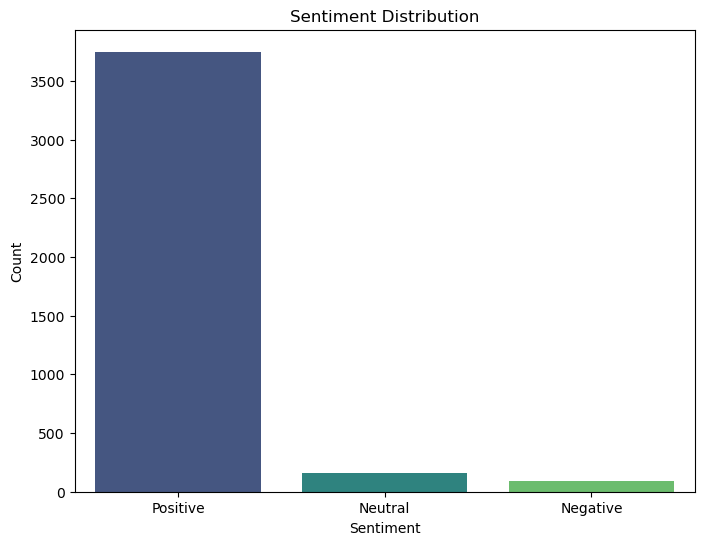

In [47]:
# to show the distribution of reviews sentiments in the dataset
sentiment_counts = data2['sentiment'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [48]:

print(Positive.shape,Neutral.shape,Negative.shape)

(3749, 3) (158, 3) (93, 3)


#### Applying Over Sampling

In [49]:
# # RandomOverSampler to handle imbalanced data
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=0) 
# X_res,Y_res=ros.fit_sample(X,Y)


from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0) 
X_resampled, Y_resampled = ros.fit_resample(X, Y)


In [50]:
from collections import Counter
print(sorted(Counter(Y_resampled).items()))

[('Negative', 3749), ('Neutral', 3749), ('Positive', 3749)]


In [51]:
X_resampled.shape,Y_resampled.shape

((11247, 1), (11247,))

In [52]:
# Checking out both old and new data
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_resampled)))

Original dataset shape Counter({'Positive': 3749, 'Neutral': 158, 'Negative': 93})
Resampled dataset shape Counter({'Positive': 3749, 'Neutral': 3749, 'Negative': 3749})


In [53]:
# Creating X output to dataframe
X1 = pd.DataFrame(X_resampled,columns =['Processed_Review'])


In [54]:
# Creating Y output to dataframe for merging
Y1 = pd.DataFrame(Y_resampled,columns = ['sentiment'])

In [55]:
# Merging the X & Y output to final data
Final_data = pd.concat([X1,Y1],axis =1)
Final_data.head()

,Processed_Review,sentiment
0,purchase black fridaypros great price even sal...,Positive
1,purchase two amazon echo plus two dot plus fou...,Positive
2,average alexa option show thing screen still l...,Neutral
3,good product exactly want good price,Positive
4,rd one purchase buy one niece case compare one...,Positive


In [56]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11247 entries, 0 to 11246
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Processed_Review  11247 non-null  object
 1   sentiment         11247 non-null  object
dtypes: object(2)
memory usage: 175.9+ KB


sentiment
Positive    3749
Neutral     3749
Negative    3749
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Reviews Sentiment')

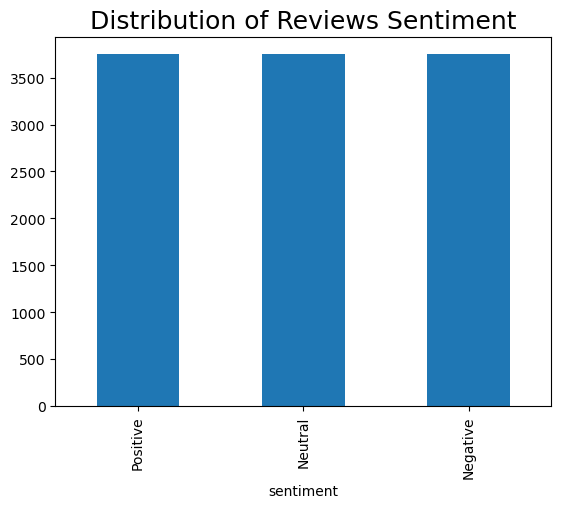

In [57]:
# Using Matplotlib to plot the final data & show distribution of reviews sentiment in the dataset

print(Final_data.sentiment.value_counts())
Final_data['sentiment'].value_counts().plot(kind = 'bar')
plt.title("Distribution of Reviews Sentiment",size = 18)

In [58]:
df = Final_data.sample(frac=0.1,random_state=0)

#Dropping missing values
df.dropna(inplace = True)

df.head()

,Processed_Review,sentiment
8805,buy think would great read book play game howe...,Neutral
9736,good tablet kid lot appts download game,Neutral
125,item work expect great product,Positive
10143,great beginner like child limit use many apps ...,Neutral
10937,buy kindle past time one come defective port b...,Neutral


### Train & Test Split Data

In [59]:
# Splitting data into training set and validation
X_train,X_test,y_train,y_test = train_test_split(df['Processed_Review'],df['sentiment'],\
                                                test_size=0.1 ,random_state=0)
print('Load %d training examples and %d validation example.\n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n',X_train.iloc[10])    

Load 1012 training examples and 113 validation example.

Show a review in the training set : 
 daughter love easy navigate hard break


#### Bag of Words

*The aim of this project is to classify the reviews into positive, neutral and negative sentiment.

There are two main steps which are involved:

1. We need to find word embedding to convert text into a numerical representation.
2. We fit the numerical representations of text to machine learning algorithms or deep learning architectures.
* One common approach of word embedding is frequency based embedding viz Bag of Words (BoW) model. BoW model learns a vocabulary list from a given corpus and represents each document based on some counting methods of words. Here, we will explore the model performance using BoW with supervised learning algorithms.

Here's the workflow of this part.

1. Preprocess raw reviews to cleaned reviews.
2. Create BoW using CountVectorizer/Tfidfvectorizer in Sklearn.
3. Transform review text to numerical representations (feature vectors).
4. Fit feature vectors to supervised learning algorithm (Naive Bayes, Logistic regression, etc.).
5. Improve the model performance by GridSearch.



#### Text Preprocessing

The following text preprocessing methods are implemented to convert raw reviews to cleaned review making it easier to do feature extraction in the next step.

1. Remove non-character such as digits and symbols.
2. Convert to lower case.
3. Remove stop words such as "the" and "and" if needed.
4. Convert to root words by stemming if needed.

In [60]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [61]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 daughter love easy navigate hard break


#### CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

* Now as we have cleaned all reviews the next step is converting the reviews into numerical representations for a machine learning algorithm.



* We will use CountVectorizer which implements both tokenization and occurrence counting in a single class provided by the Sklearn library. The output is a sparse matrix representation of the document.

In [62]:
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)

# Get the feature names from the vocabulary dictionary
feature_names = countVect.get_feature_names_out()

print("Number of features: %d \n" % len(feature_names))
print("Show some feature names:\n", feature_names[::1000])


Number of features: 1511 

Show some feature names:
 ['ability' 'playtime']


In [63]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect,y_train)

MultinomialNB()

In [64]:
def modelEvaluation(predictions):
    #print model evaluation to predicted result
    
    print("\nAccuarcy on validation set :{:.4f}".format(accuracy_score(y_test,predictions)))
    print("\nClassification report : \n",metrics.classification_report(y_test,predictions))
    print('\nConfusion Matrix : \n',metrics.confusion_matrix(y_test,predictions))      

In [65]:
# evaluate the model on validation set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuarcy on validation set :0.8938

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.85      0.90      0.88        39
    Positive       0.91      0.83      0.87        35

    accuracy                           0.89       113
   macro avg       0.89      0.89      0.89       113
weighted avg       0.89      0.89      0.89       113


Confusion Matrix : 
 [[37  0  2]
 [ 3 35  1]
 [ 0  6 29]]


#### TfidfVectorizer with Logistic Regression

* Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

* In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [66]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf= tfidf.fit_transform(X_train_cleaned)

# Get the feature names from the vocabulary dictionary
feature_names = tfidf.get_feature_names_out()

print("Number of features: %d \n" % len(feature_names))
print("Show some feature names:\n", feature_names[::1000])

# Logistic Regression

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features: 691 

Show some feature names:
 ['able']


LogisticRegression()

In [67]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['love' 'easy' 'great' 'play' 'read' 'alexa' 'kid' 'price' 'well' 'ok']

Top 10 features with the largest coefficients : 
['return' 'update' 'bad' 'know' 'terrible' 'th' 'poor' 'try' 'minute'
 'youtube']


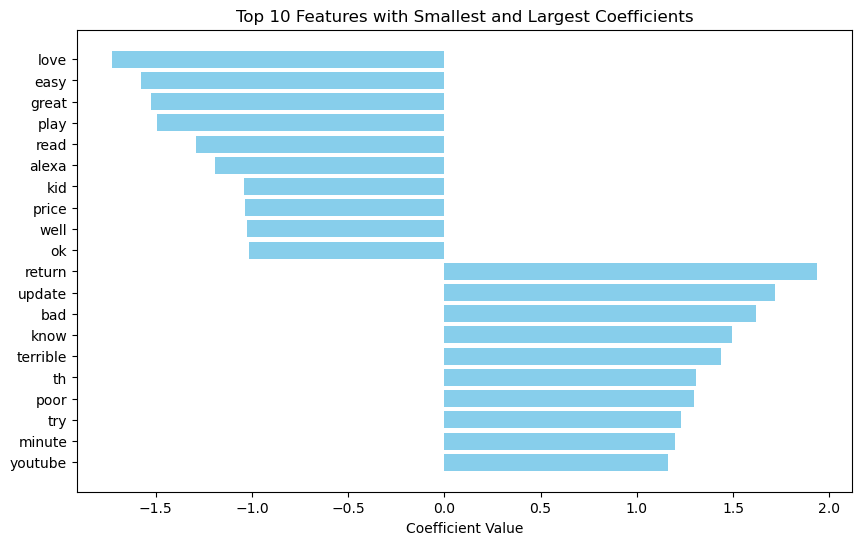

In [68]:
# To create a graph displaying the coefficients of the features
import matplotlib.pyplot as plt

# Get feature names
feature_names = np.array(tfidf.get_feature_names_out())

# Sort coefficients
sorted_coef_index = lr.coef_[0].argsort()

# Concatenate top 10 features with the smallest coefficients and top 10 features with the largest coefficients
top_coefficients = np.concatenate((feature_names[sorted_coef_index[:10]], feature_names[sorted_coef_index[:-11:-1]]))
top_coefficients_values = np.concatenate((lr.coef_[0][sorted_coef_index[:10]], lr.coef_[0][sorted_coef_index[:-11:-1]]))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_coefficients)), top_coefficients_values, color='skyblue')
plt.yticks(range(len(top_coefficients)), top_coefficients)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features with Smallest and Largest Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have largest coefficients at the top
plt.show()


In [69]:
# Evaluating on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuarcy on validation set :0.9292

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      1.00      0.96        39
     Neutral       0.88      0.92      0.90        39
    Positive       1.00      0.86      0.92        35

    accuracy                           0.93       113
   macro avg       0.94      0.93      0.93       113
weighted avg       0.93      0.93      0.93       113


Confusion Matrix : 
 [[39  0  0]
 [ 3 36  0]
 [ 0  5 30]]


#### TfidfVectorizer with Linear SVM by using SGD

Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [74]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf= tfidf.fit_transform(X_train_cleaned)

# Get the feature names from the vocabulary dictionary
feature_names = tfidf.get_feature_names_out()

print("Number of features: %d \n" % len(feature_names))
print("Show some feature names:\n", feature_names[::1000])

# SVM

from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge" ,penalty='l2')
clf.fit(X_train_tfidf,y_train)

Number of features: 691 

Show some feature names:
 ['able']


SGDClassifier()

In [75]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = clf.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['overall' 'play' 'sometimes' 'well' 'easy' 'age' 'great' 'love' 'control'
 'definitely']

Top 10 features with the largest coefficients : 
['terrible' 'return' 'minute' 'poor' 'exchange' 'update' 'never' 'dark'
 'case' 'bad']


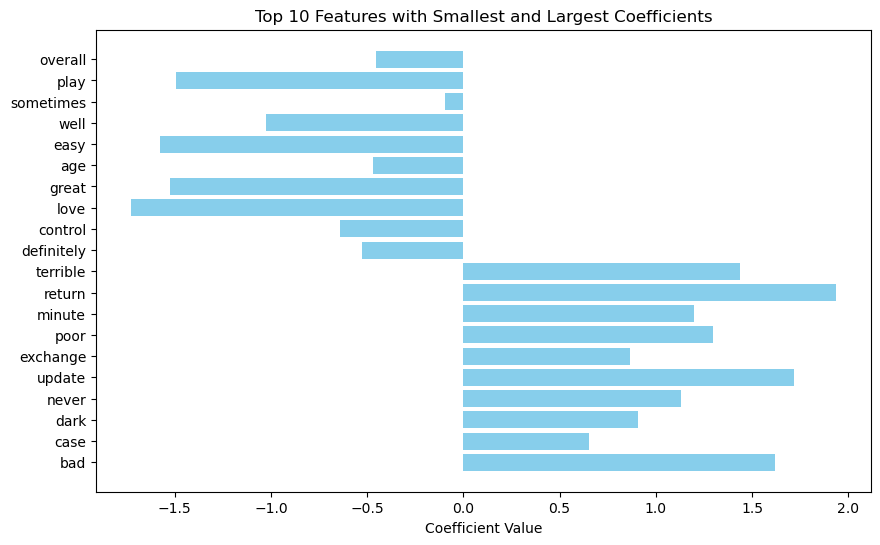

In [76]:
# To create a graph displaying the coefficients of the features
import matplotlib.pyplot as plt

# Get feature names
feature_names = np.array(tfidf.get_feature_names_out())

# Sort coefficients
sorted_coef_index = clf.coef_[0].argsort()

# Concatenate top 10 features with the smallest coefficients and top 10 features with the largest coefficients
top_coefficients = np.concatenate((feature_names[sorted_coef_index[:10]], feature_names[sorted_coef_index[:-11:-1]]))
top_coefficients_values = np.concatenate((lr.coef_[0][sorted_coef_index[:10]], lr.coef_[0][sorted_coef_index[:-11:-1]]))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_coefficients)), top_coefficients_values, color='skyblue')
plt.yticks(range(len(top_coefficients)), top_coefficients)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features with Smallest and Largest Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have largest coefficients at the top
plt.show()

In [77]:
# Evaluating on the validaton set
predictions = clf.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuarcy on validation set :0.9204

Classification report : 
               precision    recall  f1-score   support

    Negative       0.95      1.00      0.97        39
     Neutral       0.84      0.97      0.90        39
    Positive       1.00      0.77      0.87        35

    accuracy                           0.92       113
   macro avg       0.93      0.92      0.92       113
weighted avg       0.93      0.92      0.92       113


Confusion Matrix : 
 [[39  0  0]
 [ 1 38  0]
 [ 1  7 27]]


#### Using XGBoost Classifier

some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [81]:
# XGBoost

from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" % len(tfidf.get_feature_names_out())) # use get_feature_names_out() instead
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Encode target classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train_encoded)


Number of features : 691 

Show some feature names : 
 ['able']


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [83]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = xgb.feature_importances_.argsort()

print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))



Top 10 features with smallest coefficients :
['yr' 'online' 'white' 'often' 'offer' 'october' 'occasionally' 'ny'
 'numerous' 'normal']

Top 10 features with largest coefficients : 
['bright' 'call' 'smart' 'replace' 'night' 'reset' 'little' 'ok' 'love'
 'speaker']


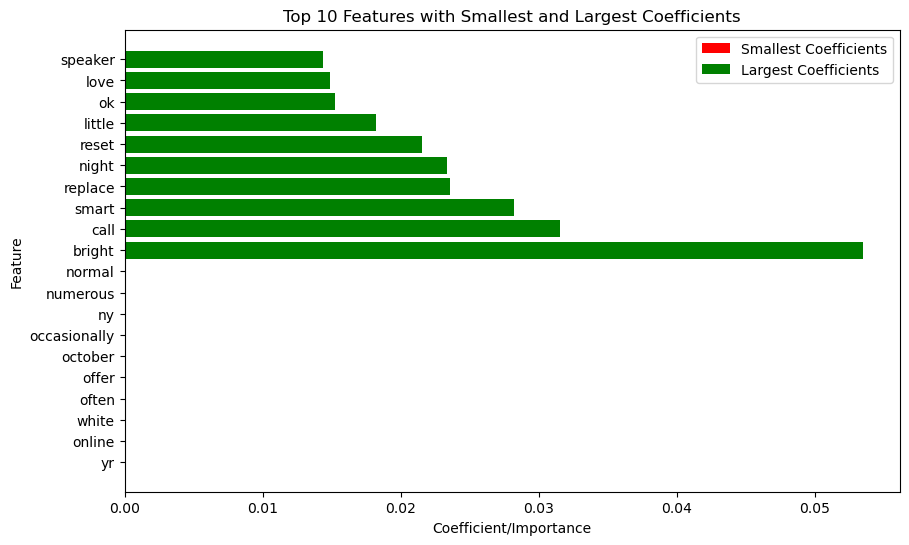

In [84]:
import matplotlib.pyplot as plt

# Get top 10 features with smallest and largest coefficients
top_smallest_features = feature_names[sorted_coef_index[:10]]
top_largest_features = feature_names[sorted_coef_index[:-11:-1]]

# Get corresponding coefficients/importances
smallest_coefficients = xgb.feature_importances_[sorted_coef_index[:10]]
largest_coefficients = xgb.feature_importances_[sorted_coef_index[:-11:-1]]

# Plotting
plt.figure(figsize=(10, 6))

plt.barh(top_smallest_features, smallest_coefficients, color='red', label='Smallest Coefficients')
plt.barh(top_largest_features, largest_coefficients, color='green', label='Largest Coefficients')

plt.xlabel('Coefficient/Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features with Smallest and Largest Coefficients')
plt.legend()

plt.show()


#### Pipeline and GridSearch

We will build a pipeline in the Sklearn library to streamline the workflow and use GridSearch on the pipeline model to implement hyperparameter tuning for both the vectorizer and classifier at once.

In [87]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuarcy on validation set :0.9381

Classification report : 
               precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        39
     Neutral       0.90      0.95      0.93        39
    Positive       0.94      0.89      0.91        35

    accuracy                           0.94       113
   macro avg       0.94      0.94      0.94       113
weighted avg       0.94      0.94      0.94       113


Confusion Matrix : 
 [[38  0  1]
 [ 1 37  1]
 [ 0  4 31]]


#### Word2Vec

Another common approach of word embedding is the prediction based embedding like Word2Vec model. Briefly, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and Skip-Gram model. Both are Shallow Neural Networks which learn weights for the word vector representations.

Here, we will train Word2Vec model to create our own word vector representation using gensim library. Then we will fit the feature vectors of the reviews to the Random Forest Classifier. Here's the workflow of this part: -

* Parse review text to sentences (Word2Vec model takes a list of sentences as inputs).
* Create vocabulary list using Word2Vec model.
* Transform each review into numerical representation by computing average feature vectors of words therein
* Fit the average feature vectors to Random Forest Classifier


#### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocabulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [88]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VARUN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
# Splitting review text into parsed sentences using NLTK 's Punkt tokenizer

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review,tokenizer,remove_stopwords= False):
    
    #parse text into sentence
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences=[]
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0 :
            sentences.append(cleanText(raw_sentence,remove_stopwords,split_text=True))
    return sentences

# Parsing each review in the training set into sentences
sentences = []
for review in X_train_cleaned :
    sentences += parseSent(review ,tokenizer)
    
print('%d parsed sentence in the training set\n' %len(sentences))
print('Show a parsed sentence in the training set : \n',sentences[10])


1012 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['daughter', 'love', 'easy', 'navigate', 'hard', 'break']


#### Creating Vocabulary List using Word2Vec Model

As we have a set of cleaned and parsed sentences from the training data, we will train our own word vector representations by specifying the embedding dimension (= length of feature vector).

In [90]:
from gensim.models import Word2Vec

num_features = 300  # embedding dimension
min_word_count = 10
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context")  # save trained word2vec model

print("Number of words in the vocabulary list : %d \n" % len(w2v.wv.index_to_key))  # 4016
print("Show first 10 words in the vocabulary list: \n", w2v.wv.index_to_key[:10])


Training Word2Vec model ...

Number of words in the vocabulary list : 416 

Show first 10 words in the vocabulary list: 
 ['buy', 'tablet', 'use', 'good', 'great', 'work', 'get', 'one', 'amazon', 'kindle']


### Averaging Feature Vectors

Now we have created a vocabulary list of words with each word having a word representation(ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the vocabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review

In [91]:
def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the vocabulary list created
    '''
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key)  # index_to_key is the vocabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords += 1
            featureVec = np.add(featureVec, model.wv[word])
            isZeroVec = False
    if not isZeroVec:
        featureVec /= nwords
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0  # Assigning counter here
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter += 1  # Incrementing counter
    return reviewFeatureVecs


In [92]:
# Getting feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set: %d feature vectors with %d dimensions" % trainVector.shape)

# Getting feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set: %d feature vectors with %d dimensions" % testVector.shape)


Training set: 1012 feature vectors with 300 dimensions
Validation set: 113 feature vectors with 300 dimensions


In [93]:
# Getting feature vectors for training set
trainVector = getAvgFeatureVecs(X_train, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)

# Getting feature vectors for validation set
testVector = getAvgFeatureVecs(X_test, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

Training set : 1012 feature vectors with 300 dimensions
Validation set : 113 feature vectors with 300 dimensions


#### Random Forest Classifer

We will now train the Random Forest Classifier using feature vectors of reviews in the training set.

In [94]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuarcy on validation set :0.4690

Classification report : 
               precision    recall  f1-score   support

    Negative       0.49      0.69      0.57        39
     Neutral       0.45      0.38      0.42        39
    Positive       0.44      0.31      0.37        35

    accuracy                           0.47       113
   macro avg       0.46      0.46      0.45       113
weighted avg       0.46      0.47      0.46       113


Confusion Matrix : 
 [[27  6  6]
 [16 15  8]
 [12 12 11]]


#### Applying LSTM

Long Short Term Memory(LSTM) Networks are a special kind of the Recurrent Neural Networks(RNN) capable of learning long-term dependencies. LSTM can be very useful in text mining problems as it involves dependencies in the sentences which can be caught in the "memory" of the LSTM. Here, we will train a simple LSTM and LSTM with Word2Vec embedding for classifying the reviews into positive and negative sentiments using Keras library.

Simple LSTM

We need to preprocess the text data to 2D tensor before we begin fitting it into a simple LSTM. Firstly we will tokenize the corpus by considering only top words (top_words = 20000) and transforming reviews to numerical sequences using the trained tokenizer. Lastly we will make it sure that all the numerical sequences have the same length (maxlen=100) for modelling by truncating the long reviews and padding shorter reviews having zero values.

For constructing a simple LSTM, we will use embedding class in Keras to building up the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should also note that the embedding class provides a convenient way to map discrete words into a continuous vector space but it doesn't take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we will use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 prediction for the two classes (positive sentiment and negative sentiment). As it is a binary classification problem log loss is used as the loss function(binary_crossentropy in Keras). ADAM optimization algorithm will be used.

Here's the workflow in this part: -

* Prepare X_train and X_test to 2D tensor.
* Train a simple LSTM (embedding layer => LSTM layer => dense layer).
* Compile and fit the model using log loss function and ADAM optimizer.

In [95]:
df = Final_data.sample(frac=0.1, random_state=0)

# Drop missing values
df.dropna(inplace=True)

# Convert the sentiments
df.sentiment.replace(('Positive','Negative','Neutral'),(1,0,2),inplace=True)

df.head()


,Processed_Review,sentiment
8805,buy think would great read book play game howe...,2
9736,good tablet kid lot appts download game,2
125,item work expect great product,1
10143,great beginner like child limit use many apps ...,2
10937,buy kindle past time one come defective port b...,2


In [99]:
#  Splitting data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['sentiment'], \
                                                    test_size=0.1, random_state=1)

In [102]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3

# Assuming X_train, X_test, y_train, and y_test are your training and testing data

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #Considering only top 20000 words in the corpus
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# One-Hot Encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape)
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape)


X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


In [104]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential

# Constructing a Simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(Dropout(0.2))  # Adding dropout regularization after Embedding layer
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
model1.add(Dense(nb_classes, activation='softmax'))
model1.summary()

# Compiling LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model Evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2691971 (10.27 MB)
Trainable params: 2691971 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/3


32/32 [==============================] - 16s 307ms/step - loss: 0.6462 - accuracy: 0.4377
Epoch 2/3
32/32 [==========================

In [108]:
# Print model summary
model1.summary()

# Check the number of layers in the model
print("Number of layers in the model:", len(model1.layers))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2691971 (10.27 MB)
Trainable params: 2691971 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Number of layers in the model: 4


In [109]:
# Getting weight matrix of the embedding layer
embedding_weights = model1.layers[0].get_weights()[0]
print("Size of weight matrix in the embedding layer : ", embedding_weights.shape) #(20000, 128)

# Getting weight matrix of the LSTM layer
lstm_weights = model1.layers[2].get_weights()
print("Size of weight matrix in the LSTM layer : ", lstm_weights[0].shape) #(128, 512)  weight dim of LSTM - w

# Getting weight matrix of the output layer
dense_weights = model1.layers[3].get_weights()[0]
print("Size of weight matrix in the output layer : ", dense_weights.shape) #(128, 3) weight dim of dense layer


Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the LSTM layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 3)


#### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy for converting the numerical sequence of words into a word embedding but it doesn't take the semantic similarity of the words into account. The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights we will use pretrained word embeddings for initializing the weight of an embedding layer. Here, we will use the Word2Vec embedding trained in Part 4 for intializing the weights of embedding layer in LSTM.

* Load pretrained word embedding model.
* Construct embedding layer using embedding matrix as weights.
* Train a LSTM with Word2Vec embedding (embedding layer => LSTM layer => dense layer).
* Compile and fit the model using log loss function and ADAM optimizer.

In [111]:
# Loading pretrained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")

# Getting Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors
print("Shape of embedding matrix : ", embedding_matrix.shape) #(vocabulary size, embedding dimension)


Shape of embedding matrix :  (416, 300)


In [113]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical  # Importing to_categorical from keras.utils

top_words = embedding_matrix.shape[0]  # 4016
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3

# Vectorizing X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words)  # Considering all words in the embedding matrix
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# One-Hot Encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape)
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape)


X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


In [115]:
# Constructing LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # Updated dropout parameters
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compiling model
model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         124800    
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 344835 (1.32 MB)
Trainable params: 344835 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
32/32 [==============================] - 18s 379ms/step - loss: 0.6325 - accuracy: 0.3923
Epoch 2/3
32/32 [==============================] -

In [116]:
# Getting weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# Getting weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# Getting weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (416, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 3)


#### Optional Tasks: Topic Modelling

Latent Dirichlet Allocation(LDA)

In [117]:
import nltk
nltk.download('wordnet')

doc_complete = data2["Processed_Review"].tolist()
doc_clean = [cleanText(doc).split() for doc in doc_complete]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VARUN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [118]:
import gensim
from gensim import corpora

In [119]:
dictionary = corpora.Dictionary(doc_clean)
print(dictionary)

Dictionary<3415 unique tokens: ['able', 'access', 'accomplish', 'ad', 'add']...>


In [120]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 3),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 2),
  (34, 1)],
 [(6, 1),
  (26, 2),
  (34, 1),
  (35, 4),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1)],
 [(35, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 

In [121]:
from gensim.models import LdaModel

In [122]:
NUM_TOPICS = 9
ldamodel = LdaModel(doc_term_matrix, num_topics=NUM_TOPICS, id2word=dictionary, passes=30)

In [123]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)
    print()

(0, '0.031*"tablet" + 0.025*"apps" + 0.024*"amazon" + 0.022*"work" + 0.016*"use" + 0.015*"get" + 0.012*"great" + 0.011*"store" + 0.011*"well" + 0.010*"buy"')

(1, '0.050*"kid" + 0.034*"play" + 0.033*"love" + 0.033*"game" + 0.033*"tablet" + 0.020*"year" + 0.019*"get" + 0.018*"enjoy" + 0.017*"great" + 0.015*"buy"')

(2, '0.037*"battery" + 0.029*"life" + 0.028*"tap" + 0.024*"sound" + 0.023*"good" + 0.018*"great" + 0.017*"quality" + 0.015*"amazon" + 0.013*"portable" + 0.012*"best"')

(3, '0.051*"great" + 0.028*"good" + 0.023*"price" + 0.021*"buy" + 0.017*"product" + 0.016*"child" + 0.015*"watch" + 0.014*"tablet" + 0.011*"kid" + 0.011*"lot"')

(4, '0.043*"read" + 0.035*"tablet" + 0.029*"use" + 0.029*"book" + 0.023*"good" + 0.018*"kindle" + 0.016*"need" + 0.014*"great" + 0.011*"buy" + 0.011*"like"')

(5, '0.033*"great" + 0.032*"use" + 0.028*"recommend" + 0.027*"good" + 0.021*"product" + 0.018*"picture" + 0.018*"work" + 0.018*"would" + 0.016*"camera" + 0.015*"quality"')

(6, '0.037*"kindle" +

In [124]:
word_dict = {}
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict["Topic # " + "{}".format(i)] = [i[0] for i in words]

In [125]:
pd.DataFrame(word_dict)

,Topic # 0,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8
0,tablet,kid,battery,great,read,great,kindle,love,echo
1,apps,play,life,good,tablet,use,read,buy,alexa
2,amazon,love,tap,price,use,recommend,light,tablet,love
3,work,game,sound,buy,book,good,easy,one,show
4,use,tablet,good,product,good,product,love,old,use
5,get,year,great,child,kindle,picture,screen,kindle,great
6,great,get,quality,watch,need,work,book,gift,music
7,store,enjoy,amazon,tablet,great,would,small,purchase,easy
8,well,great,portable,kid,buy,camera,hand,year,home
9,buy,buy,best,lot,like,quality,get,great,device


In [126]:
ldamodel.show_topic(0, topn = 20)

[('tablet', 0.031312354),
 ('apps', 0.02535431),
 ('amazon', 0.023735363),
 ('work', 0.022010487),
 ('use', 0.015891967),
 ('get', 0.014569787),
 ('great', 0.011559217),
 ('store', 0.011401136),
 ('well', 0.01087359),
 ('buy', 0.009628519),
 ('google', 0.009066946),
 ('device', 0.008473819),
 ('set', 0.007814752),
 ('download', 0.007757653),
 ('easy', 0.007669047),
 ('need', 0.007225738),
 ('prime', 0.0069262083),
 ('time', 0.0067117703),
 ('app', 0.006612785),
 ('book', 0.0065706247)]

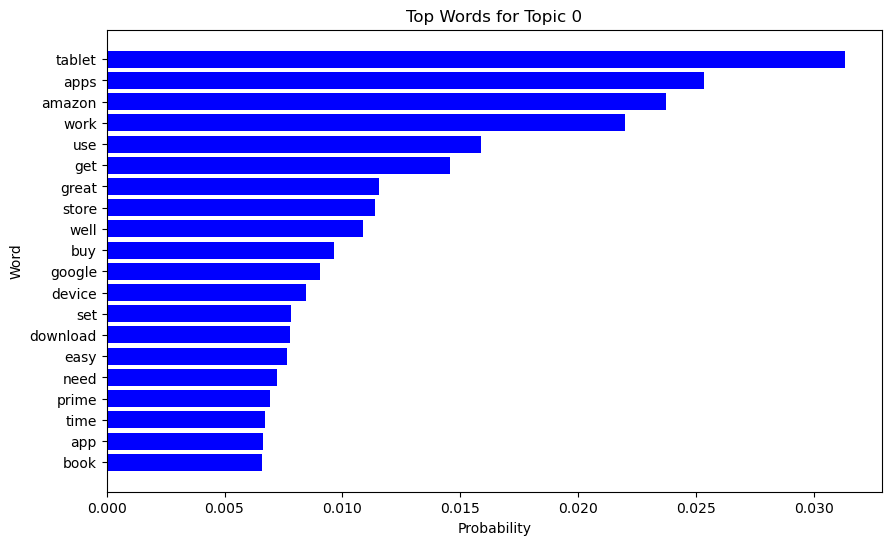

In [130]:
import matplotlib.pyplot as plt

# Get the top words for topic 0
topic_words = ldamodel.show_topic(0, topn=20)

# Extract words and their probabilities
words = [word for word, prob in topic_words]
probabilities = [prob for word, prob in topic_words]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(words, probabilities, color='blue')
plt.xlabel('Probability')
plt.ylabel('Word')
plt.title('Top Words for Topic 0')
plt.gca().invert_yaxis()  # Invert y-axis to display the most probable word at the top
plt.show()


In [131]:
!pip install pyLDAvis
     


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pyLDAvis from https://files.pythonhosted.org/packages/6b/5a/66364c6799f2362bfb9b7100bc1ce6ffcdfe7f17e8d2e85a591bfe427643/pyLDAvis-3.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for funcy from https://files.pythonhosted.org/packages/d5/08/c2409cb01d5368dcfedcbaffa7d044cc8957d57a9d0855244a5eb4709d30/funcy-2.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
    --------------------------------------- 0.1/2.6 MB 544.7 kB/s eta 0:00:05
    --------------------------------------- 0.1/2.6 MB 544.7 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.6 MB 711.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/2.6 MB 711.9 kB/s eta 0:00:04
   --

In [132]:
import pyLDAvis.gensim

#### Displaying Results & Getting Insights

In [133]:
Lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(Lda_display)

#### Creating a Wordcloud

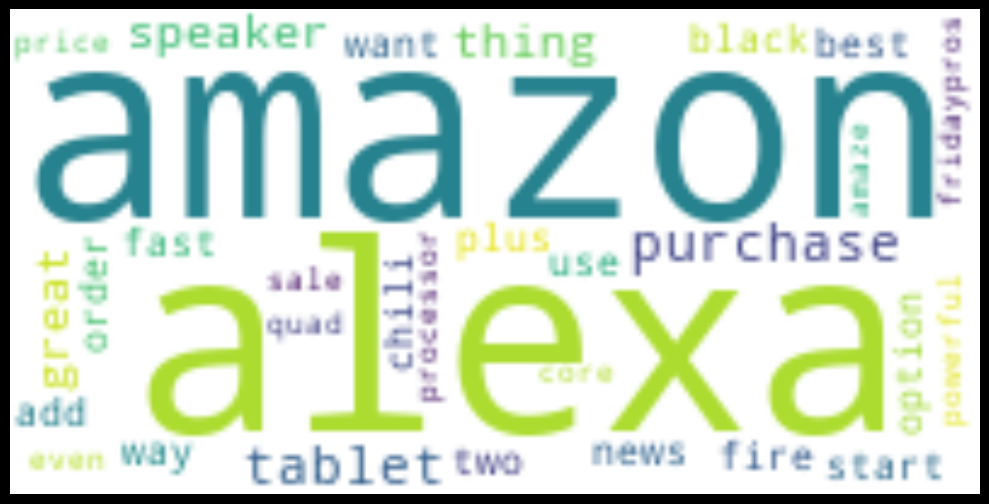

In [135]:
from wordcloud import WordCloud, STOPWORDS
txt = data2["Processed_Review"].values
wc = WordCloud(width=200, height=100, background_color="white", stopwords=STOPWORDS).generate(str(txt))
fig = plt.figure(figsize=(10,10), facecolor='k', edgecolor='w')
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()